In [ ]:
#|default_exp embed

# Embeddings

> Simple embedding model

In [ ]:
#|hide
from fastdownload import FastDownload

In [ ]:
#|export
from fastai.tabular.all import *
from hits_recsys.collab import *

In [ ]:
url = 'https://raw.githubusercontent.com/MenshikovDmitry/TSU_AI_Course/main/module_1.%20Recommender%2BDevOps/dataset/'
files = ('ratings_train.dat ratings_test.dat movies.dat users.dat').split()
d = FastDownload()

In [ ]:
paths = L(d.download(url+f) for f in files); paths

(#4) [Path('/home/slakter/.fastdownload/archive/ratings_train.dat'),Path('/home/slakter/.fastdownload/archive/ratings_test.dat'),Path('/home/slakter/.fastdownload/archive/movies.dat'),Path('/home/slakter/.fastdownload/archive/users.dat')]

In [ ]:
df, df_test = read_movielens(paths[0],paths[2]), read_movielens(paths[1],paths[2])
df.head()

,userId,movieId,rating,title
0,3539,2478,5,Three Amigos! (1986)
1,1358,2478,1,Three Amigos! (1986)
2,2565,2478,1,Three Amigos! (1986)
3,4819,2478,2,Three Amigos! (1986)
4,5763,2478,1,Three Amigos! (1986)


In [ ]:
ds = TfmdDataset(df)

In [ ]:
#|export
class Subset:
    def __init__(self, ds, indices):store_attr()
    def __getitem__(self,idx):
        return self.ds[self.indices[idx]]
    def __len__(self): return len(self.indices)

In [ ]:
train, val = RandomSubsetSplitter(train_sz=0.7, valid_sz=0.3)(ds)

In [ ]:
dls = DataLoaders.from_dsets(ds,Subset(ds,val), bs=1024)

Model with user and movies embeddings 

In [ ]:
#|export
class EmbeddingDotBias(Module):
    def __init__(self, n_factors, n_users, n_items, y_range=None):
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [Embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, x):
        users,items = x[:,0],x[:,1]
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

In [ ]:
model = EmbeddingDotBias(50, len(ds.user_map), len(ds.movie_map), y_range=(0,5.5))
model = torch.compile(model)
learn = Learner(dls, model, loss_func=MSELossFlat())

epoch,train_loss,valid_loss,time
0,0.840455,0.809399,00:33
1,0.758017,0.696144,00:23
2,0.697178,0.588011,00:40
3,0.624461,0.505621,00:20
4,0.552766,0.455671,00:19
5,0.485536,0.435418,00:19
6,0.441625,0.432875,00:21


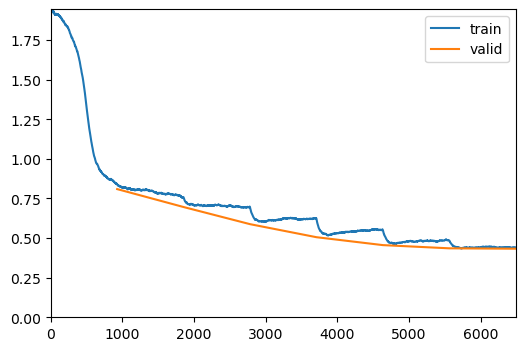

In [ ]:
#|eval: false
learn.fit_one_cycle(7,6e-3, wd=0.1, cbs=[ShowGraphCallback()])

### RMSE loss

In [ ]:
ds_test = ds.test_ds(df_test)

In [ ]:
#|eval: false
torch.sqrt(learn.get_preds(dl=TfmdDL(ds_test, bs=512), with_loss=True)[2].mean())

TensorBase(0.8408)

## Adapter for api

In [ ]:
#|export
class EmbedAdapter:
    def __init__(self, device=None): 
        self.device = ifnone(device, default_device())
        
    def save(self, fname):
        torch.save(self.model, fname)
    
    def load(self, fname):
        obj = torch.load(fname)
        assert obj.__class__ == EmbeddingDotBias, "Class missmatch"
        self.model = obj
    
    def norm(self, x, m, std=None): return (x-m)/std if std else (x-m)/m
    
    @delegates(Learner.fit)
    def fit(self, ds, n_epoch=5, lr=5e-3, wd=0.1, bs=512, **kwargs):
        self.model = EmbeddingDotBias(50, len(ds.user_map), len(ds.movie_map), y_range=(0,5.5)).to(self.device)
        train, val = RandomSubsetSplitter(train_sz=0.9, valid_sz=0.1)(ds)
        dls = DataLoaders.from_dsets(Subset(ds,train),Subset(ds,val), bs=bs)
        self.learn = Learner(dls, self.model, loss_func=MSELossFlat())
        self.learn.fit_one_cycle(n_epoch, lr, wd=wd, **kwargs)

    def predict(self, xb, yb=None):
        with torch.no_grad(): 
            ratings = self.model(xb)
        if yb is not None: return (ratings, F.mse_loss(ratings, yb))
        return ratings
    
    def recommend(self, movies, ratings, topk=5, filter_seen=True):
        movs = self.model.i_weight(movies)
        average_mov = (movs * self.norm(ratings[:,None], ratings.mean())).sum(0)
        res = F.cosine_similarity(average_mov, self.model.i_weight.weight)
        if not filter_seen: return res.topk(topk)
        res = res.topk(topk + len(movies))
        mask = ~torch.isin(res.indices,movies)
        return (res[0][mask][:topk], res[1][mask][:topk])
    
    def similar_movies(self, movie_id: int, topk=5):
        m_v = self.model.i_weight(tensor(movie_id, device=self.device))
        return F.cosine_similarity(m_v, self.model.i_weight.weight).topk(topk+1).indices[1:]

In [ ]:
model = EmbedAdapter()

epoch,train_loss,valid_loss,time
0,0.786427,0.790494,00:08


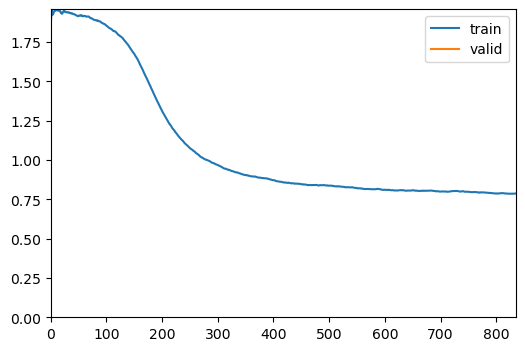

In [ ]:
model.fit(ds,n_epoch=1, bs=1024, cbs=[ShowGraphCallback()])

In [ ]:
model.save('./models/model.pt')

In [ ]:
xb, yb = to_device(dls.one_batch())

In [ ]:
model.predict(xb,yb)[1]

tensor(0.6840, device='cuda:0')

In [ ]:
movs = tensor([ds.encode([s])[0] for s in ds.movie_map if 'star wars' in s.lower()] + [1, 2, 3])[2:]
rats = tensor([5] * (len(movs) - 3) + [1] * 3, dtype=torch.float)
movs, rats = to_device((movs, rats))

In [ ]:
ds.decode(model.recommend(movs,rats,10)[1]).pprint()

Braveheart (1995)
Terminator, The (1984)
Stripes (1981)
Star Wars: Episode IV - A New Hope (1977)
Die Hard (1988)
Terminator 2: Judgment Day (1991)
Saving Private Ryan (1998)
Shawshank Redemption, The (1994)
Breakfast Club, The (1985)
Ferris Bueller's Day Off (1986)


In [ ]:
m_id = 3149
ds.decode([m_id])
ds.decode(model.similar_movies(m_id)).pprint()

Star Wars: Episode IV - A New Hope (1977)
Shawshank Redemption, The (1994)
Stripes (1981)
Terminator, The (1984)
Aliens (1986)


In [ ]:
serv = ModelService.load('./models', EmbedAdapter())

In [ ]:
#|eval: false
serv.eval(ds_test, bs=4096*4)

0.9154611229896545